# Прогноз объемов Авто-Траст

Есть отчет в 1С "Отчет по пак-листам". Объем данных можно выгрузить с начала 2015 года.

Требуется разработать модель, которая будет прогнозировать на каждый день:
- объем работ для склада в строках 
- объем продаж в рублях 
- объем грузовых мест

Объемы в строках нужны для расчета персонала общего. Объем грузовых мест пригодится для расчета кол-ва персонала в зоне отгрузки.

**Цель:** прогнозирование временного ряда (день, неделя, месяц) с целью корректировки ШР на складах и выставленеи объемов продаж и закупа.

## Загрузка данных

In [ ]:
# установка пакета для чтения файлов в формате xls
# pip install openpyxl

In [ ]:
# импорт библиотек для работы
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
import time

import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV
from catboost import Pool, cv
from sklearn.metrics import accuracy_score
from scipy.signal import find_peaks

import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances

pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore')

Файл перед загрузкой нужно отредактировать. Колонки должны называться строго как в примере ниже. Вид, в котором выгружает 1С - не подходит. Выглядеть он должен так:  
![image-4.png](attachment:image-4.png)

In [ ]:
# загрузка данных из файла
df = pd.read_excel('array.xlsx', index_col=[0], parse_dates=[0]) 
# сортировка индексов
df.sort_index(inplace=True)

print(f'Загружены данные за период {min(df.index)} - {max(df.index)}')

Загружены данные за период 2020-01-03 00:00:00 - 2022-08-28 00:00:00


In [ ]:
# выведем последние 5 строк
df.tail()

picking  amount       income  loads  holiday
date                                                    
2022-08-24    32667  119868  30368352.50  20344        0
2022-08-25    31435   99598  28055369.18  19480        0
2022-08-26    30333  103285  27522253.52  19513        0
2022-08-27     7299   18296   7208401.35   5023        0
2022-08-28    16363   47394  14541160.30   9123        0

In [ ]:
# вывод общей информации для проверки типов данных
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 965 entries, 2020-01-03 to 2022-08-28
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   picking  965 non-null    int64  
 1   amount   965 non-null    int64  
 2   income   965 non-null    float64
 3   loads    965 non-null    int64  
 4   holiday  965 non-null    int64  
dtypes: float64(1), int64(4)
memory usage: 45.2 KB


In [ ]:
# миллионы сократим на 1000
df['income'] = df['income']/1000

In [ ]:
# общая информация о данных
df.describe()

picking         amount        income         loads     holiday
count    965.000000     965.000000    965.000000    965.000000  965.000000
mean   28171.921244   93179.926425  22821.363300  15482.465285    0.079793
std    14530.773142   50529.902495  11559.120177   7512.889238    0.271113
min        1.000000       2.000000      0.466400      1.000000    0.000000
25%    20550.000000   63927.000000  16101.927540  11413.000000    0.000000
50%    30051.000000  101379.000000  25229.146680  17196.000000    0.000000
75%    36723.000000  122539.000000  29768.442760  20086.000000    0.000000
max    82379.000000  524976.000000  54132.616600  39041.000000    1.000000

### Описание данных

`picking` - строк отгрузки  
`amount` - кол-во отгруженных БЕ  
`income` - сумма отгрузки, руб  
`loads` - кол-во грузовых мест  
`holiday` - признак выходного/праздничного дня

## Анализ данных

Проверим на выбросы наш датасет.

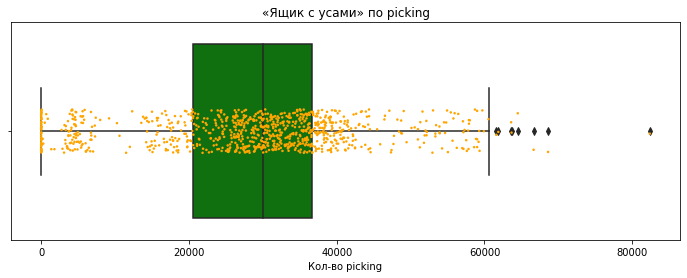

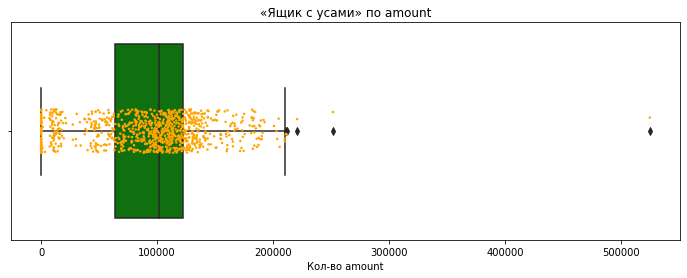

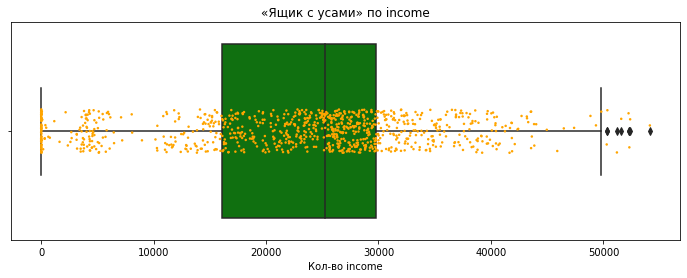

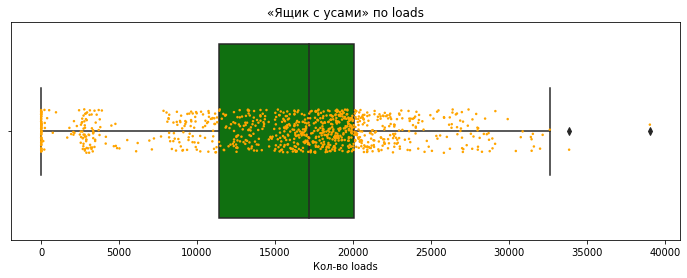

In [ ]:
for col in df.columns[:-1]:
    plt.figure(figsize=(12,4))
    ax = sns.boxplot(x=col, data=df, color="green")
    
    ax = sns.stripplot(x=col, data=df, color="orange", jitter=1, size=2.5)
    plt.title(f'«Ящик с усами» по {col}')
    plt.xlabel(f'Кол-во {col}');

В данных есть выбросы, мы их удалим перед обучением, пока трогать не будем.

### Скользящее среднее

Чтобы во временном ряду снизить колебания, применим скользящее среднее.

In [ ]:
# напишем функцию для построения графиков
def plot_rolling_mean(df, win_n):
    for col in df.columns[:-1]:
        rolling_mean = df[col].rolling(window=win_n).mean()
        plt.figure(figsize=(16,6))
        plt.title(f'{col} со скользящим средним = {win_n} дней')
        plt.plot(rolling_mean, "g", label="Скользящее среднее")
        plt.plot(df[col][win_n:], label=f"Кол-во {col}", alpha=.5)
        plt.legend(loc="upper left")

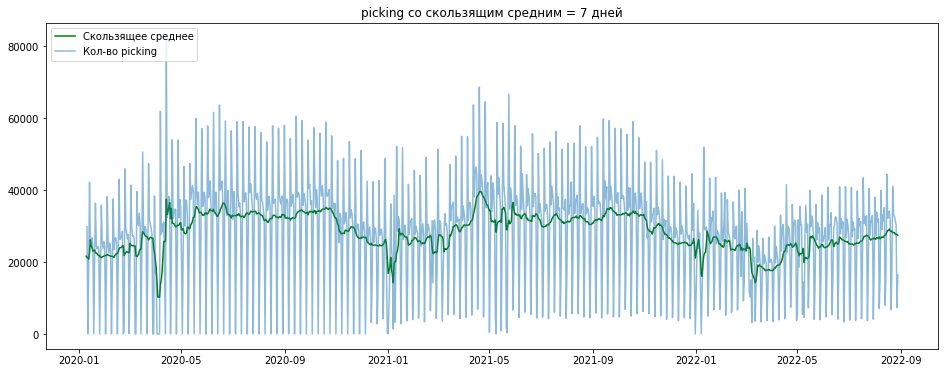

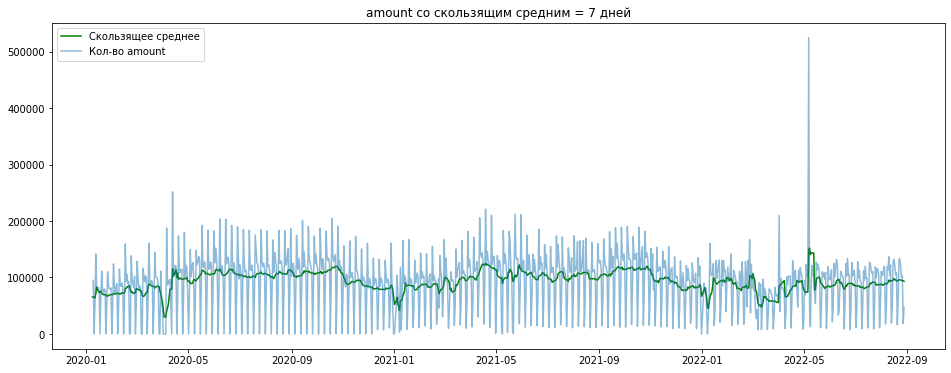

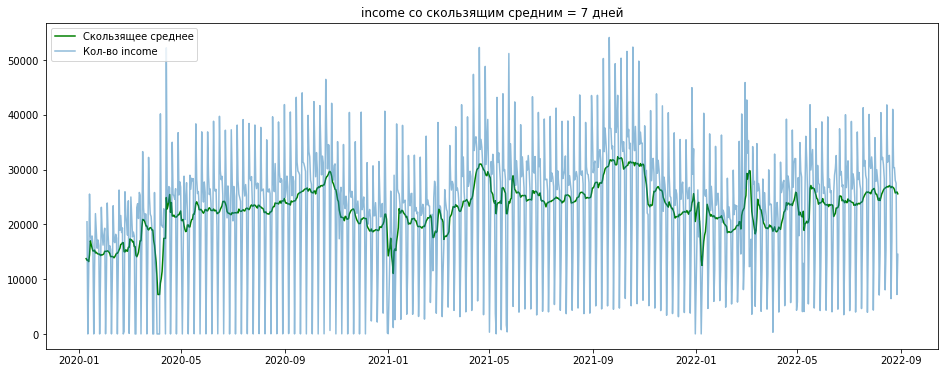

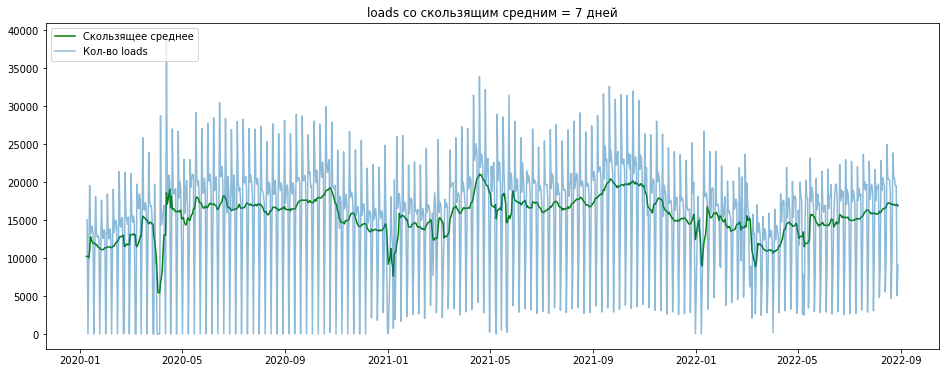

In [ ]:
plot_rolling_mean(df, 7)

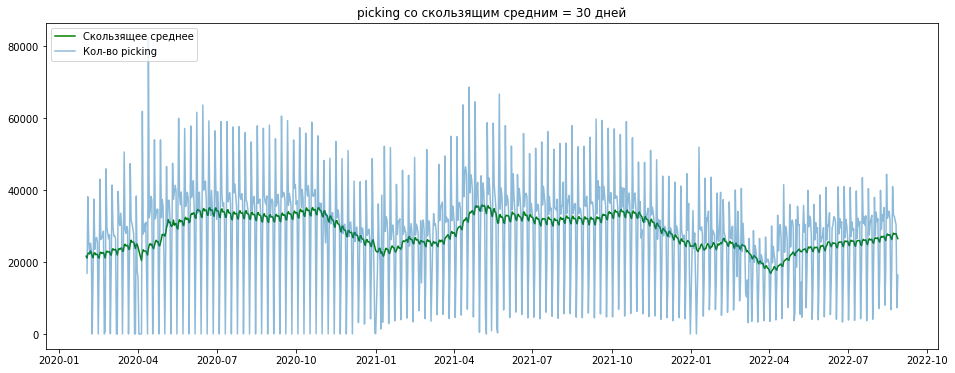

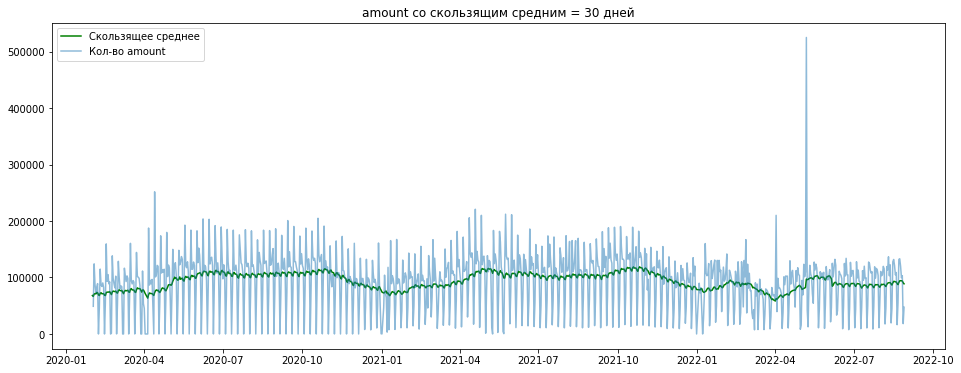

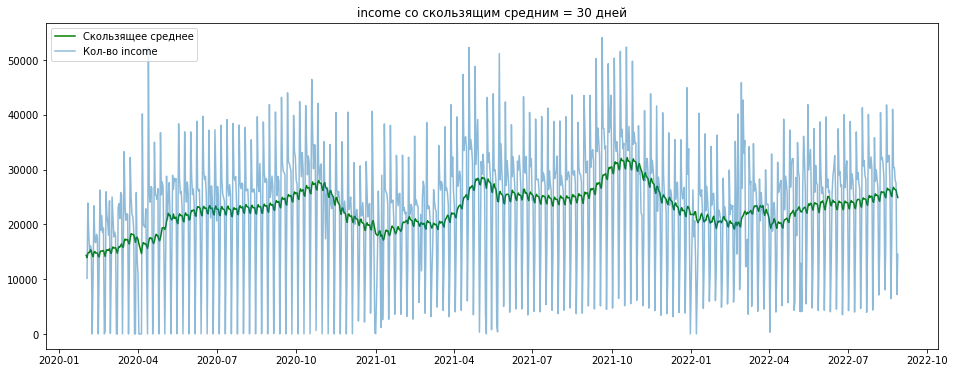

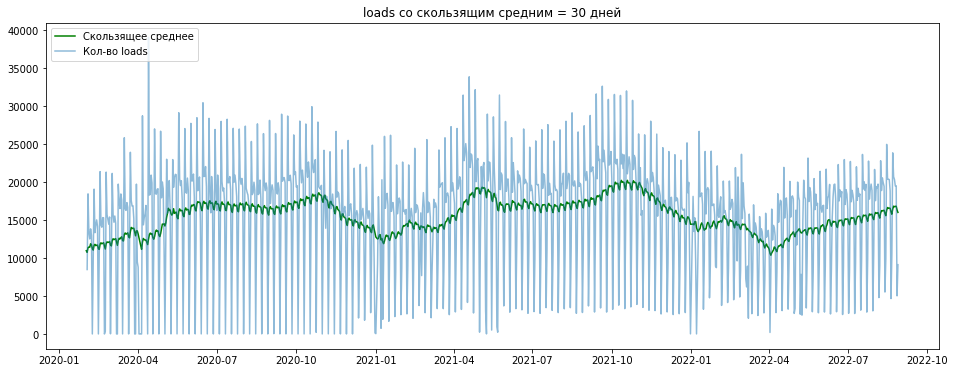

In [ ]:
plot_rolling_mean(df, 30)

### Тренды и сезонность

Чтобы лучше понимать временной ряд, разберём тренды и сезонность.  
**Тренд** — плавное изменение среднего значения ряда без повторяющихся закономерностей. Например: ежегодное увеличение объёма продаж.  
**Сезонность** — циклично повторяющиеся закономерности во временном ряду. Допустим, рост продаж санок зимой.

In [ ]:
# раскладываем временной ряд на три составляющие: тренд, сезонность и остаток (шум)
def decomposed(df, col):
    decomposed = seasonal_decompose(df['2020':'2021'][col], extrapolate_trend='freq', period=30) 
    
    # строим графики
    plt.figure(figsize=(12, 10))
    plt.subplot(311)
    decomposed.trend.plot(ax=plt.gca())
    plt.title(f'Тренд {col}')
    plt.xlabel('период')
    
    plt.subplot(312)
    decomposed.seasonal.plot(ax=plt.gca())
    plt.title(f'Сезонность {col}')
    plt.xlabel('период')
    
    plt.subplot(313)
    decomposed.resid.plot(ax=plt.gca()) 
    plt.title(f'Шум {col}')
    plt.xlabel('период')
    plt.tight_layout()

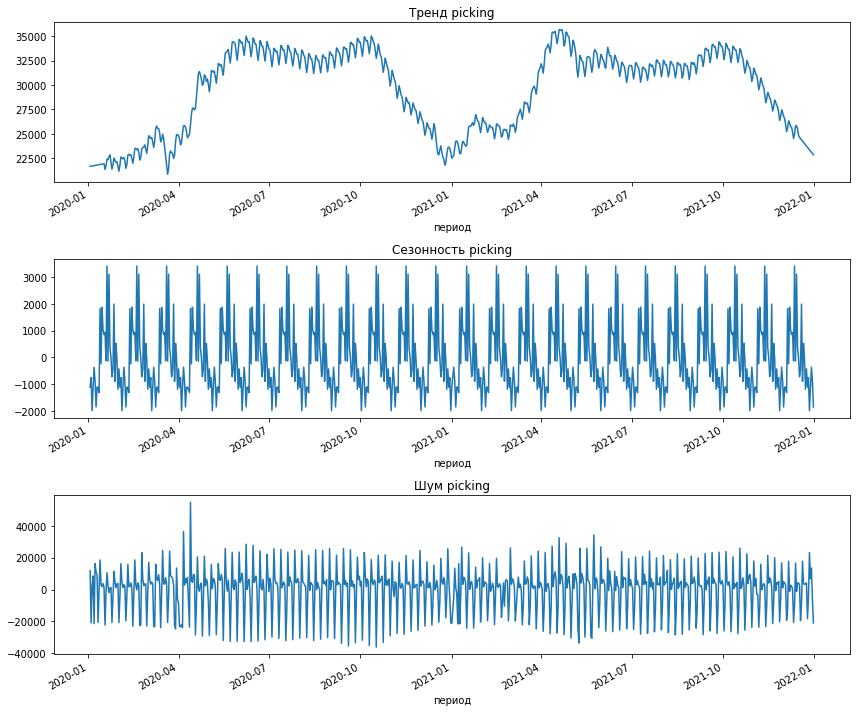

In [ ]:
decomposed(df, 'picking')

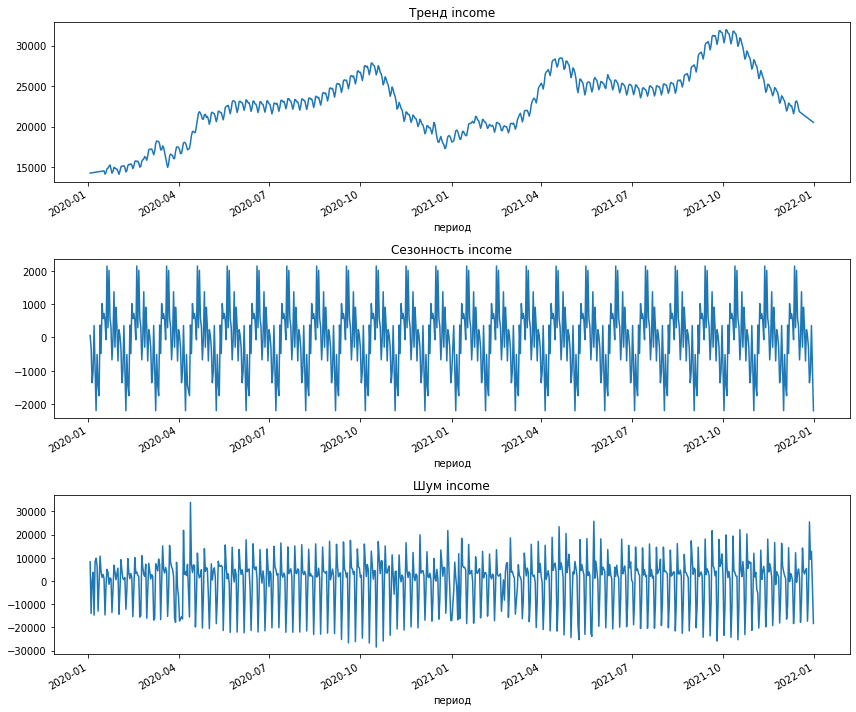

In [ ]:
decomposed(df, 'income')

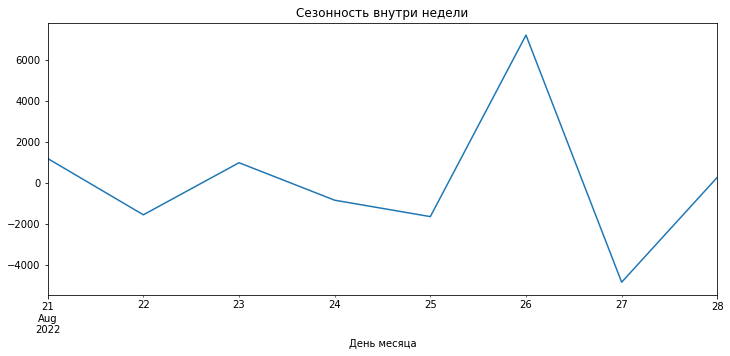

In [ ]:
decomposed = seasonal_decompose(df['2022-06-01':'2022-08-28']['picking'], extrapolate_trend='freq', period=30) 
decomposed.seasonal.tail(8).plot(title='Сезонность понедельно', figsize=(12, 5))
plt.title('Сезонность внутри недели')
plt.xlabel('День месяца')
plt.show();

### Стационарные ряды и разности временного ряда

Прогнозировать данные помогают стационарные ряды. Процесс стационарный, если его распределение со временем не меняется. Например: к такому процессу относятся периодические колебания значений. Узнать распределение временного ряда нельзя. Поэтому стационарные временные ряды — это ряды, у которых среднее и стандартное отклонение не меняются. Когда среднее и стандартное отклонение первого ряда меняется медленнее второго, то первый ряд «более стационарный», чем второй.
Чтобы ряд сделать стационарным, найдём разности его значений. Разности временного ряда — это набор разностей между соседними элементами временного ряда, т. е. из каждого значения вычитается предыдущее.

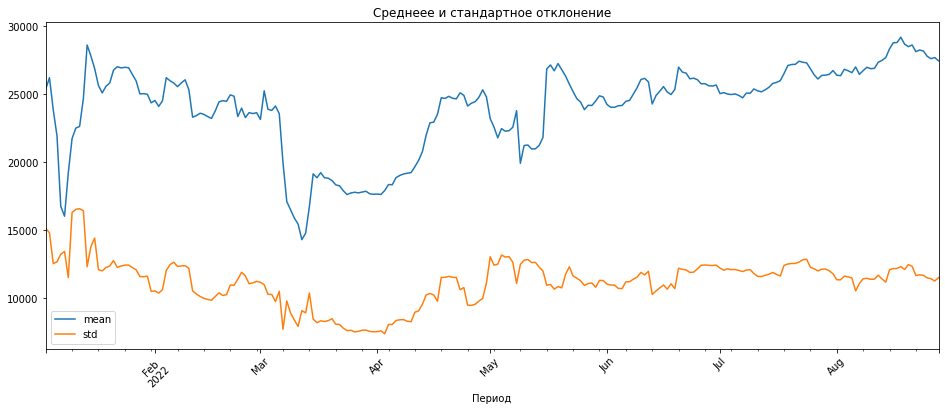

In [ ]:
df['mean'] = df['picking'].rolling(7).mean()
df['std'] = df['picking'].rolling(7).std()
df[['mean', 'std']]['2022'].plot(kind='line', style='-', figsize=(16,6), rot=45)
plt.title('Среднеее и стандартное отклонение')
plt.xlabel('Период');

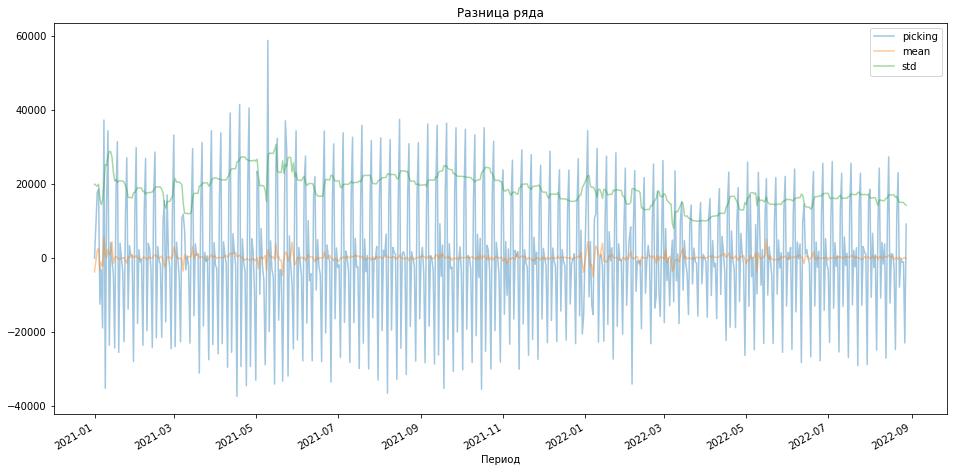

In [ ]:
# сделаем копию датасета, чтобы не перезаписывать исхдные данные
df_copy = df[['picking']].copy()
plt.figure(figsize=(16, 8))
# вычисляем разность ряда
df_copy['picking'] = df_copy - df_copy.shift()
df_copy['mean'] = df_copy['picking'].rolling(7).mean()
df_copy['std'] = df_copy['picking'].rolling(7).std()
df_copy['2021':'2022'].plot(ax=plt.gca(), alpha=.42)
plt.title('Разница ряда')
plt.xlabel('Период')
plt.show();

## Обучение

### Подготовка признаков

In [ ]:
# добавляем признаки по дате
df['month'] = df.index.month
df['day'] = df.index.day
df['dayofweek'] = df.index.dayofweek

df.tail()

picking  amount       income  loads  holiday          mean  \
date                                                                     
2022-08-24    32667  119868  30368.35250  20344        0  28147.857143   
2022-08-25    31435   99598  28055.36918  19480        0  27763.142857   
2022-08-26    30333  103285  27522.25352  19513        0  27589.285714   
2022-08-27     7299   18296   7208.40135   5023        0  27669.000000   
2022-08-28    16363   47394  14541.16030   9123        0  27435.857143   

                     std  month  day  dayofweek  
date                                             
2022-08-24  11666.774082      8   24          2  
2022-08-25  11479.611411      8   25          3  
2022-08-26  11421.771341      8   26          4  
2022-08-27  11252.713451      8   27          5  
2022-08-28  11500.726288      8   28          6

In [ ]:
# добавляем признаки со смещенеием занчений
for lag in range(1, 10):
    df['lag_{}'.format(lag)] = df['mean'].shift(lag)
# признак скользящего среднего по среднему    
df['rolling_mean'] = df['mean'].shift().rolling(7).mean()
# признак сезонности
df['seasonal'] = seasonal_decompose(df['picking'], extrapolate_trend='freq', period=30).seasonal
# признак тренда
df['trend'] = seasonal_decompose(df['picking'], extrapolate_trend='freq', period=30).trend
# признак скользящего окна (среднее)
df['expanding_window'] = df['picking'].expanding(7).mean()
# признак по кол-ву пиков
df['kurtosis'] = df['picking'].rolling(6).apply(lambda x: len(find_peaks(x)[0])) 
# признаки по разности рядов
for d in range(1,8):
    df['diff_{}'.format(d)] = df['picking'].diff(periods=d)
df.tail(8)

picking  amount       income  loads  holiday          mean  \
date                                                                     
2022-08-21    17995   54808  16971.72571  10510        0  28596.142857   
2022-08-22    40957  132021  41012.95614  23848        0  28106.428571   
2022-08-23    32997  133203  30388.71164  20701        0  28226.428571   
2022-08-24    32667  119868  30368.35250  20344        0  28147.857143   
2022-08-25    31435   99598  28055.36918  19480        0  27763.142857   
2022-08-26    30333  103285  27522.25352  19513        0  27589.285714   
2022-08-27     7299   18296   7208.40135   5023        0  27669.000000   
2022-08-28    16363   47394  14541.16030   9123        0  27435.857143   

                     std  month  day  dayofweek         lag_1         lag_2  \
date                                                                          
2022-08-21  12333.411591      8   21          6  28475.142857  28654.142857   
2022-08-22  11651.196560      8   22          0  28596.142857  28475.142857   
2022-08-23  11704.073705      8   23          1  28106.428571  28596.142857   
2022-08-24  11666.774082      8   24          2  28226.428571  28106.428571   
2022-08-25  11479.611411      8   25          3  28147.857143  28226.428571   
2022-08-26  11421.771341      8   26          4  27763.142857  28147.857143   
2022-08-27  11252.713451      8   27          5  27589.285714  27763.142857   
2022-08-28  11500.726288      8   28          6  27669.000000  27589.285714   

                   lag_3         lag_4         lag_5         lag_6  \
date                                                                 
2022-08-21  29163.714286  28775.000000  28761.000000  28309.428571   
2022-08-22  28654.142857  29163.714286  28775.000000  28761.000000   
2022-08-23  28475.142857  28654.142857  29163.714286  28775.000000   
2022-08-24  28596.142857  28475.142857  28654.142857  29163.714286   
2022-08-25  28106.428571  28596.142857  28475.142857  28654.142857   
2022-08-26  28226.428571  28106.428571  28596.142857  28475.142857   
2022-08-27  28147.857143  28226.428571  28106.428571  28596.142857   
2022-08-28  27763.142857  28147.857143  28226.428571  28106.428571   

                   lag_7         lag_8         lag_9  rolling_mean  \
date                                                                 
2022-08-21  27669.000000  27464.000000  27326.714286  28543.918367   
2022-08-22  28309.428571  27669.000000  27464.000000  28676.367347   
2022-08-23  28761.000000  28309.428571  27669.000000  28647.367347   
2022-08-24  28775.000000  28761.000000  28309.428571  28571.000000   
2022-08-25  29163.714286  28775.000000  28761.000000  28481.408163   
2022-08-26  28654.142857  29163.714286  28775.000000  28281.326531   
2022-08-27  28475.142857  28654.142857  29163.714286  28129.204082   
2022-08-28  28596.142857  28475.142857  28654.142857  28014.040816   

               seasonal         trend  expanding_window  kurtosis   diff_1  \
date                                                                         
2022-08-21  -183.525912  28296.298535      28177.299582       1.0  11254.0   
2022-08-22  -789.556063  28358.630033      28190.625652       1.0  22962.0   
2022-08-23   247.804411  28420.961531      28195.632292       1.0  -7960.0   
2022-08-24  -815.494276  28483.293029      28200.285120       1.0   -330.0   
2022-08-25  -432.984943  28545.624527      28203.647609       1.0  -1232.0   
2022-08-26 -1394.426620  28607.956025      28205.858775       1.0  -1102.0   
2022-08-27 -1295.817287  28670.287523      28184.171162       0.0 -23034.0   
2022-08-28  -675.719571  28732.619021      28171.921244       0.0   9064.0   

             diff_2   diff_3   diff_4   diff_5   diff_6  diff_7  
date                                                             
2022-08-21 -13555.0 -16133.0 -15222.0 -14162.0 -26390.0   847.0  
2022-08-22  34216.0   9407.0   6829.0   7740.0   8800.0 -3428.0  
2022-08-23  15002.0  26256.0   14

In [ ]:
# удалим нулевые значения
df = df.dropna()

### Обучение модели и подбор гипперпараметров

In [ ]:
random_state = 12345

In [ ]:
# сделаем копию нашего датасета
data = df.copy()
target = data['picking']
features = data.drop(['picking', 'income', 'amount', 'loads'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, shuffle=False)

In [ ]:
def objective(trial):
    
    params = {
        'metric': 'rmse', 
        'random_state': random_state,
        'n_estimators': 10000,
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.35,0.4,0.45,0.5,0.6,0.7,0.75,0.8,0.85]),
        'subsample': trial.suggest_categorical('subsample', [0.6,0.65,0.7,0.75,0.8,0.85]),
        'learning_rate': trial.suggest_categorical('learning_rate', 
                                                   [0.005,0.006,0.008,0.01,0.015,0.02,0.03]),
        'max_depth': trial.suggest_categorical('max_depth', [-1,10,20]),
        'num_leaves' : trial.suggest_int('num_leaves', 1, 300),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
        'cat_smooth' : trial.suggest_int('min_data_per_groups', 1, 100)
    }
    
    # Создаем и обучаем модель с мониторингом переобучения
    model = lgb.LGBMRegressor(**params)      
    model.fit(X_train, y_train, eval_set=[(X_test,y_test)], early_stopping_rounds=300, verbose=False)
    preds = model.predict(X_test)
    
    #Смотрим финальную метрику RMSE
    rmse = mean_squared_error(y_test, preds, squared=False)
    
    return rmse

In [ ]:
%%time
# Посчитаем время оптимизации

# Создаем задание для фреймворка
study = optuna.create_study(direction='minimize')  # Минимизируем ошибку
study.optimize(objective, n_trials=20)              # Количество итераций = 20

# Смотрим на финальные метрики
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Best score:', study.best_trial.value)

[I 2022-08-29 16:05:01,429] A new study created in memory with name: no-name-caecb9ed-7a23-483d-b03d-19ae6cc6cea5
[I 2022-08-29 16:05:02,277] Trial 0 finished with value: 2372.2796437730094 and parameters: {'reg_alpha': 4.706339674385066, 'reg_lambda': 0.0016137227141746896, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.03, 'max_depth': 20, 'num_leaves': 90, 'min_child_samples': 38, 'min_data_per_groups': 25}. Best is trial 0 with value: 2372.2796437730094.
[I 2022-08-29 16:05:09,253] Trial 1 finished with value: 1849.6762016517284 and parameters: {'reg_alpha': 1.6512320187036338, 'reg_lambda': 0.01531381732317706, 'colsample_bytree': 0.3, 'subsample': 0.6, 'learning_rate': 0.03, 'max_depth': -1, 'num_leaves': 149, 'min_child_samples': 4, 'min_data_per_groups': 45}. Best is trial 1 with value: 1849.6762016517284.
[I 2022-08-29 16:05:10,760] Trial 2 finished with value: 2713.2404140063704 and parameters: {'reg_alpha': 0.008105296686393995, 'reg_lambda': 0.001277974259920

Number of finished trials: 20
Best trial: {'reg_alpha': 1.6512320187036338, 'reg_lambda': 0.01531381732317706, 'colsample_bytree': 0.3, 'subsample': 0.6, 'learning_rate': 0.03, 'max_depth': -1, 'num_leaves': 149, 'min_child_samples': 4, 'min_data_per_groups': 45}
Best score: 1849.6762016517284
CPU times: total: 1min 28s
Wall time: 1min 4s


In [ ]:
# История оптимизации
plot_optimization_history(study)

In [ ]:
# Значимость гиперпараметров при настройке
plot_param_importances(study)

In [ ]:
# Выводим лучшие гиперпараметры
study.best_params

{'reg_alpha': 1.6512320187036338,
 'reg_lambda': 0.01531381732317706,
 'colsample_bytree': 0.3,
 'subsample': 0.6,
 'learning_rate': 0.03,
 'max_depth': -1,
 'num_leaves': 149,
 'min_child_samples': 4,
 'min_data_per_groups': 45}

In [ ]:
optuna_params = study.best_params

optuna_params['metric'] = 'rmse'
# optuna_params['random_state'] = random_state
optuna_params['n_estimators'] = 10000

In [ ]:
# Создаем и обучаем модель с подобранными гиперпараметрами
model_optuna = lgb.LGBMRegressor(**optuna_params)
model_optuna.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=300, verbose=300)

[LightGBM] [Warning] Unknown parameter: min_data_per_groups
[300]	valid_0's rmse: 1869.12
[600]	valid_0's rmse: 1867.44


LGBMRegressor(colsample_bytree=0.3, learning_rate=0.03, metric='rmse',
              min_child_samples=4, min_data_per_groups=45, n_estimators=10000,
              num_leaves=149, reg_alpha=1.6512320187036338,
              reg_lambda=0.01531381732317706, subsample=0.6)

In [ ]:
%%time
start_time = time.time()

pred_optuna = model_optuna.predict(X_test)
rmse_optuna = mean_squared_error(y_test, pred_optuna, squared=False)

end_time = time.time()
time_tst = end_time - start_time

print('RMSE модели c подбором параметров через OPTUNA:', rmse_optuna)
print('Время теста c подбором параметров через OPTUNA:', time_tst)

RMSE модели c подбором параметров через OPTUNA: 1866.5839634472334
Время теста c подбором параметров через OPTUNA: 0.02727961540222168
CPU times: total: 15.6 ms
Wall time: 27.3 ms


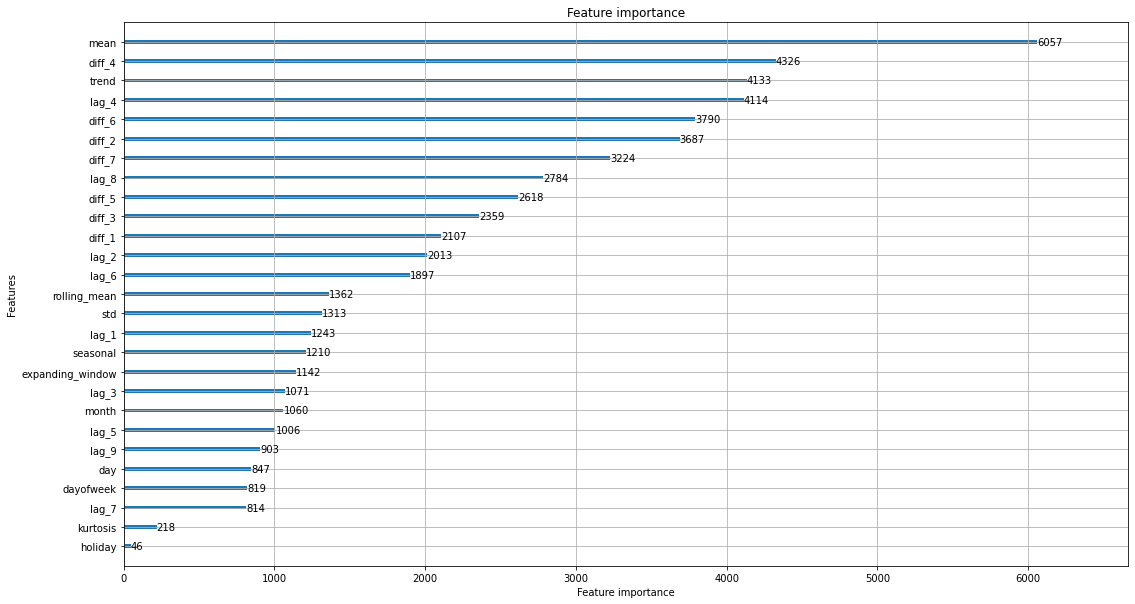

In [ ]:
# важность признаков LightGBM
lgb.plot_importance(model_optuna, figsize = (18, 10))
plt.show()

In [ ]:
a = pd.DataFrame(y_test)
a['pred_optuna'] = pred_optuna
a = a.sort_index()

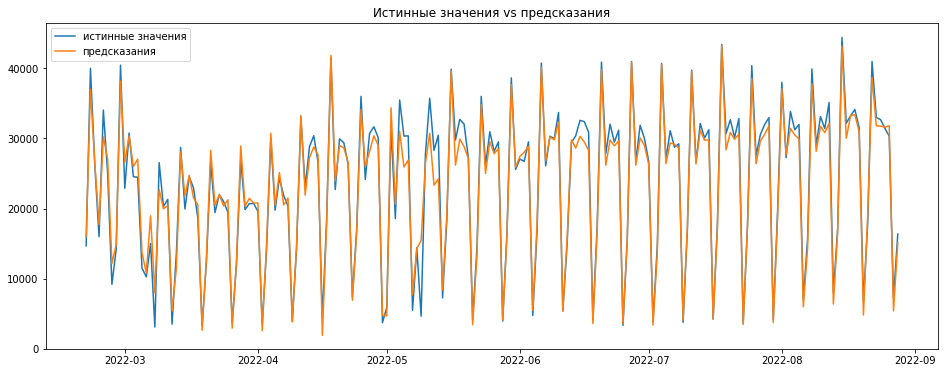

In [ ]:
plt.figure(figsize=(16,6))
plt.plot(a.index, a['picking'], label='истинные значения')
plt.plot(a.index, a['pred_optuna'], label='предсказания')
plt.title('Истинные значения vs предсказания')
plt.legend()
plt.ylim(0)
plt.show()

In [ ]:
print('MAE:', mean_absolute_error(y_test, pred_optuna))
print('R2:', r2_score(y_test, pred_optuna))
print('MAPE:', mean_absolute_percentage_error(y_test, pred_optuna))

MAE: 1339.513572124153
R2: 0.969662660999613
MAPE: 0.08994134576248568


In [ ]:
a.tail(15)

picking   pred_optuna
date                             
2022-08-14    17148  16736.476094
2022-08-15    44385  43113.266678
2022-08-16    32157  30016.305558
2022-08-17    33217  33228.619254
2022-08-18    34128  33397.645089
2022-08-19    31550  30953.234482
2022-08-20     6741   4811.592927
2022-08-21    17995  19275.996344
2022-08-22    40957  38687.299652
2022-08-23    32997  31813.687977
2022-08-24    32667  31738.759491
2022-08-25    31435  31616.976920
2022-08-26    30333  31786.858345
2022-08-27     7299   5417.908583
2022-08-28    16363  15148.776628